# Imports

In [1]:
# configure user-modules autoreload
%load_ext autoreload
%autoreload 2

import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

# import utility functions
from train_utils import *

device

device(type='cuda', index=0)

# Data

In [2]:
import torchvision.transforms as T
from loader import get_dataloaders

# make dataloaders
TARGET_SIZE = 128


class Expand:
    def __call__(self, input_tensor):
        shapes_new = list(input_tensor.size())
        mx = max(shapes_new)
        max_size = [3, mx, mx]
        for i in range(3):
            if max_size[i] > shapes_new[i]:
                shapes_new[i] = max_size[i] - input_tensor.shape[i]
                dop_torch = torch.ones(shapes_new)
                input_tensor = torch.cat((input_tensor, dop_torch), i)
        return input_tensor


transform = T.Compose([T.ToTensor(), Expand(), T.Resize((TARGET_SIZE, TARGET_SIZE))])
train_loader, val_loader = get_dataloaders('../data', train_transform=transform, test_transform=transform, transform_name=f'Expand({TARGET_SIZE}, {TARGET_SIZE})')

# show dataset size
TRAIN_SIZE = len(train_loader.dataset)
VAL_SIZE = len(val_loader.dataset)
print(f'Train size: {TRAIN_SIZE}. Val size: {VAL_SIZE}. Val ratio: {VAL_SIZE / (TRAIN_SIZE + VAL_SIZE) * 100:.2f}%')

Train size: 6777. Val size: 2261. Val ratio: 25.02%


In [46]:
from torch.utils.data import ConcatDataset, DataLoader


concat_dataset = ConcatDataset([train_loader.dataset, val_loader.dataset])
combined_dataloader = DataLoader(concat_dataset, batch_size=64, shuffle=True)

# Model

In [36]:
from models.lenet import get_lenet
from models.mobilenet import get_mobilenet, get_mobilenet_pretrained
from models.resnet import get_resnet18, get_resnet152
from models.efficient_net import get_efficientnet

# Make sure that model performs correctly
with torch.no_grad():
    features, labels = next(iter(train_loader))
    print(f'Features size: {features.size()}. Labels size: {labels.size()}')
    logits = get_mobilenet_pretrained()(features)

Features size: torch.Size([64, 3, 128, 128]). Labels size: torch.Size([64])


# Training

Train accuracy: 100.0%. Val accuracy: 99.9%
Train score: 7.99. Val score: 7.99
Train loss: 0.00. Val loss: 0.00


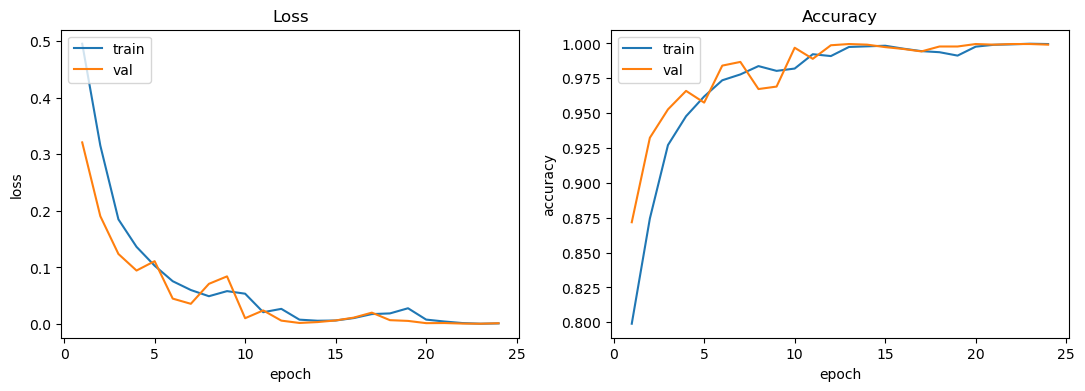

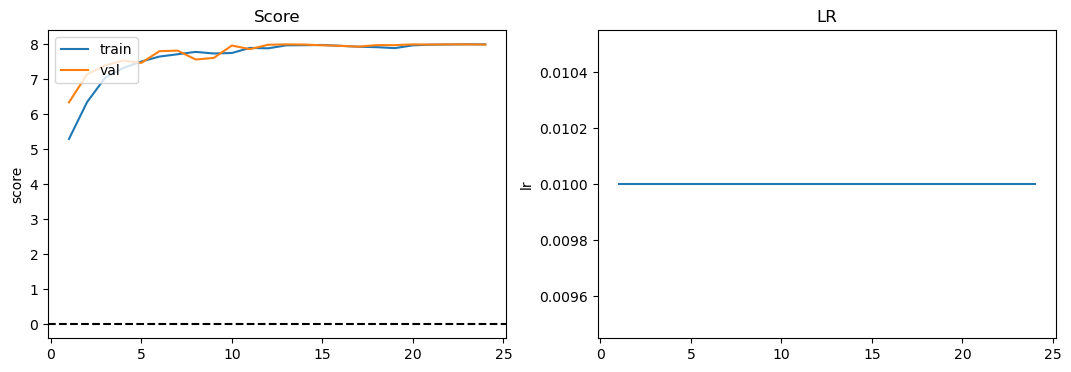

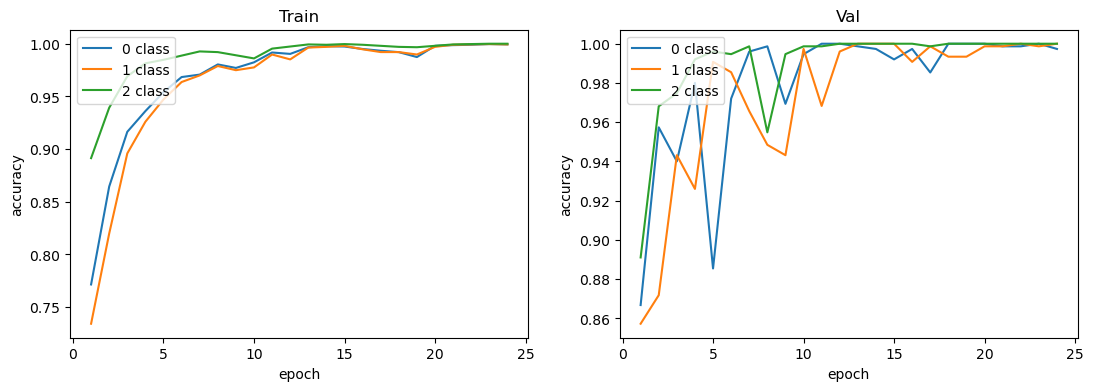

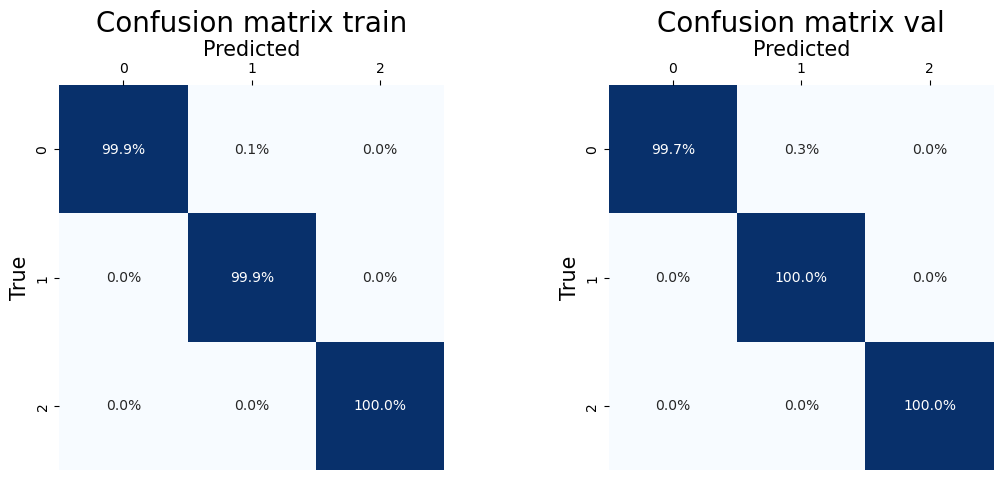

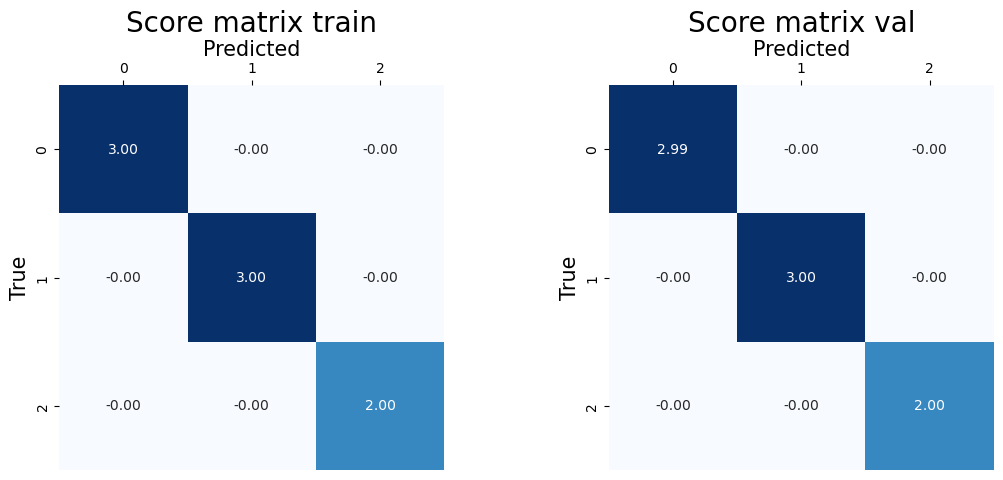

Training:   0%|          | 0/142 [00:00<?, ?it/s]

In [47]:
# import one of the criterions
from criterions import CrossEntropyLoss
from train_utils import *

LOG_WANDB = False
N_EPOCHS = 60

FACTOR = 0.3
PATIENCE = 3

model = get_resnet18().to(device)

LR = 1e-2
MOMENTUM = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = None  # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=FACTOR, patience=PATIENCE)
criterion = CrossEntropyLoss()

if LOG_WANDB:
    experiment_name = f'LeNet128'
    notes = f'''
    Optimizer: SGD({LR=}, {MOMENTUM=})
    Scheduler: ReduceLROnPlateau({FACTOR=}, {PATIENCE=})
    '''
    wandb.login()
    wandb.init(
        project='VK Hackathon',
        name=experiment_name,
        notes=notes
    )

try:
    torch.manual_seed(0)
    train_nn(model, optimizer, criterion, scheduler, train_loader=combined_dataloader, val_loader=val_loader, n_epochs=N_EPOCHS, log_wandb=LOG_WANDB)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    if LOG_WANDB:
        wandb.finish()

print('Success')

In [13]:
from pathlib import Path
from torch.utils.data import DataLoader
import PIL

files = sorted(Path('../test_data').iterdir())
print(f'Number of files: {len(files)}')
names = []
images_list = []
for filename in tqdm(files):
    # load image
    names.append(filename.name)
    image = PIL.Image.open(filename).convert('RGB')
    image = transform(image)
    images_list += [image]
test_dataloader = DataLoader(images_list, batch_size=64, shuffle=False)

Number of files: 595


  0%|          | 0/595 [00:00<?, ?it/s]

d:\anaconda3\envs\cuda_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
with torch.inference_mode():
    model.eval()
    predicted_labels = []

    for images in tqdm(test_dataloader, desc='Testing'):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            # logits: batch_size x num_classes
            predicted_labels.append(logits.argmax(dim=1).cpu())

    predicted_labels = torch.concat(predicted_labels).numpy()

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
predicted_labels_final = predicted_labels + 1
pd.value_counts(predicted_labels_final)

1    246
3    180
2    169
dtype: int64

In [ ]:
df = pd.DataFrame(list(zip(names, predicted_labels_final)), columns=['name', 'class'])
df

name  class
0      0.jpg      3
1      1.jpg      1
2     10.jpg      1
3    100.jpg      2
4    101.jpg      2
..       ...    ...
590   95.jpg      2
591   96.jpg      2
592   97.jpg      3
593   98.jpg      1
594   99.jpg      1

[595 rows x 2 columns]

In [ ]:
df.to_csv('../result.csv', sep=';', index=False)
print('Success')

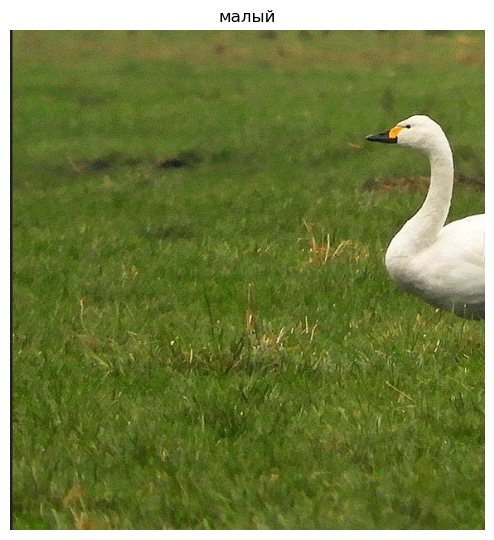

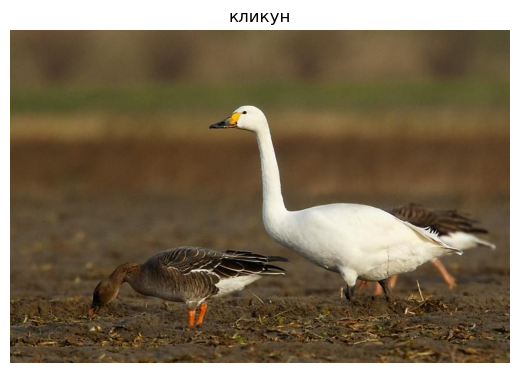

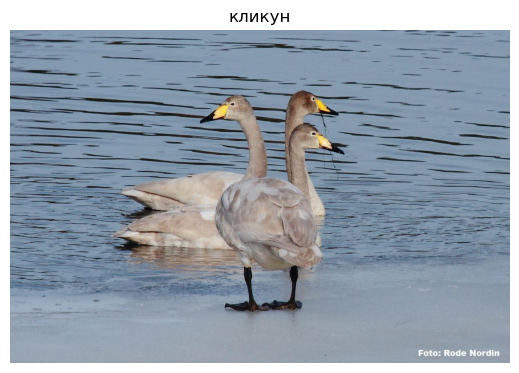

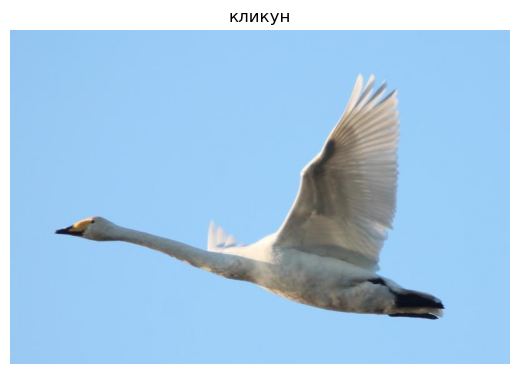

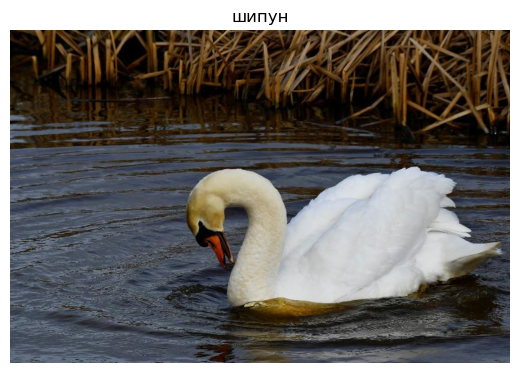

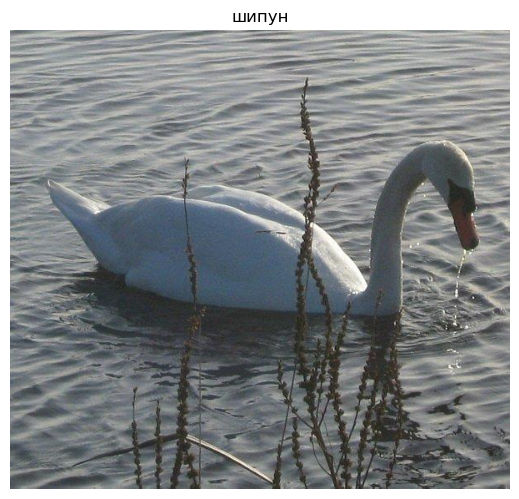

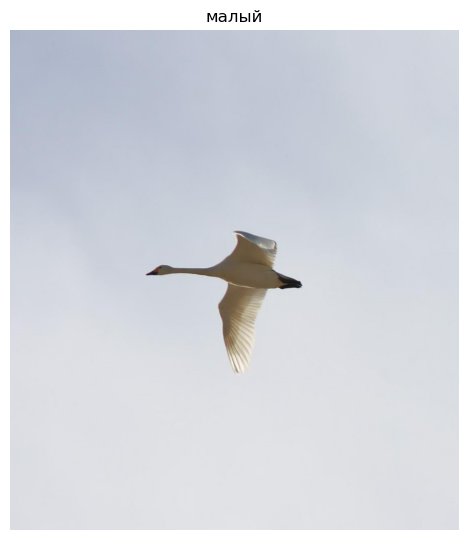

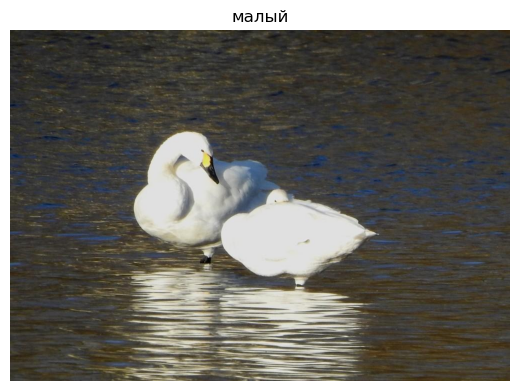

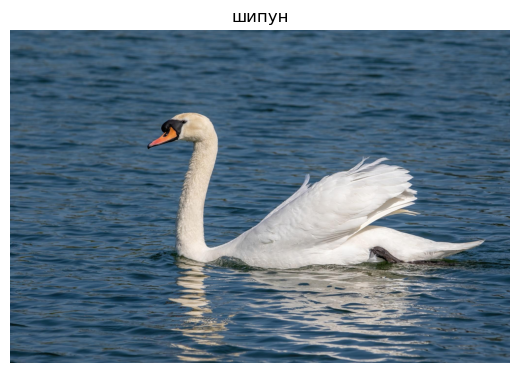

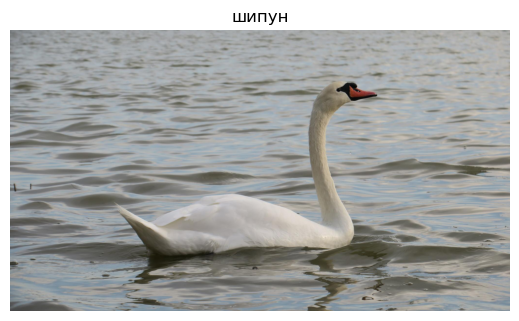

In [33]:
import torchvision.transforms as T


class_by_label = {
    1: 'малый',
    2: 'кликун',
    3: 'шипун'
}

def show_tensor(image_tensor, title=None, convert_to_image=False, i=0):
    if convert_to_image:
        image_tensor = T.ToPILImage()(image_tensor)
    plt.figure(figsize=(5, 5))
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.title(title)
    plt.savefig(f'figures/{i}.png', bbox_inches='tight')
    plt.show()

observations = np.random.choice(range(len(predicted_labels)), size=10)
for i in observations:
    filename = files[i]
    image = PIL.Image.open(filename).convert('RGB')
    show_tensor(image, title=f'{class_by_label[predicted_labels_final[i]]}', i=i)

[1061  235 1932 1096 1791  905  715 1669  847  960  144  129 1607  749
  508 1414 1305 1202 1300 1278  357  914  468  907  252] 

Предсказано:	кликун
шипун: 0.62%
кликун: 91.25%
малый: 8.13%
Верно:		кликун


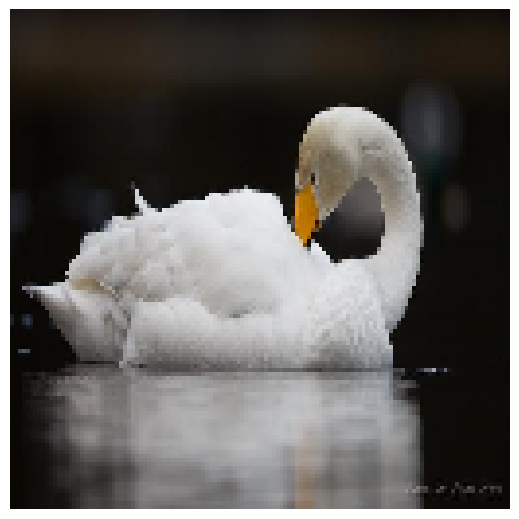


Предсказано:	шипун
шипун: 99.52%
кликун: 0.47%
малый: 0.01%
Верно:		шипун


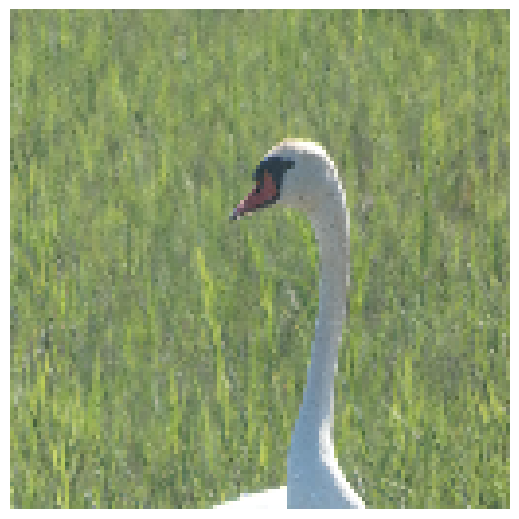


Предсказано:	малый
шипун: 0.00%
кликун: 0.62%
малый: 99.38%
Верно:		малый


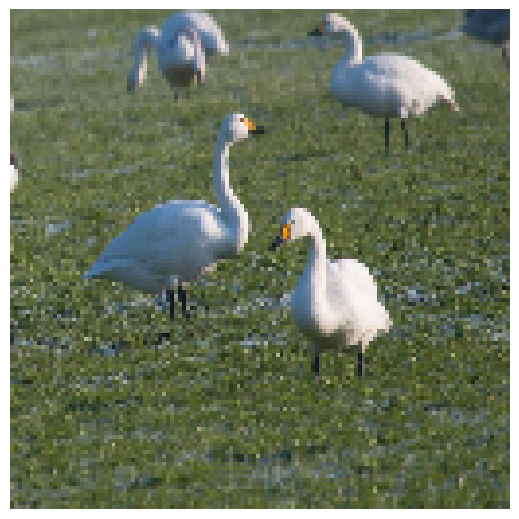


Предсказано:	кликун
шипун: 2.69%
кликун: 93.83%
малый: 3.48%
Верно:		кликун


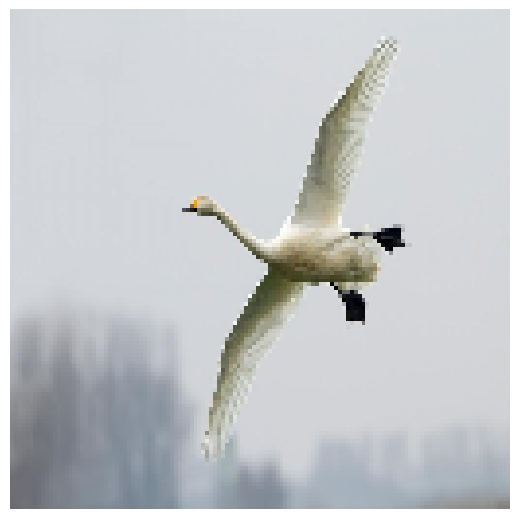


Предсказано:	малый
шипун: 0.02%
кликун: 0.83%
малый: 99.15%
Верно:		малый


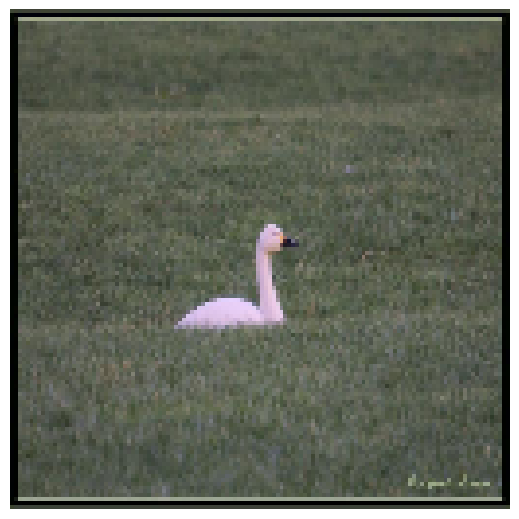


Предсказано:	кликун
шипун: 0.01%
кликун: 98.89%
малый: 1.10%
Верно:		кликун


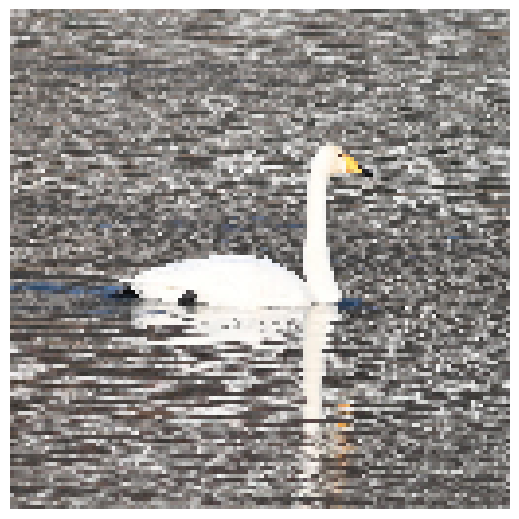


Предсказано:	кликун
шипун: 1.00%
кликун: 64.60%
малый: 34.40%
Верно:		кликун


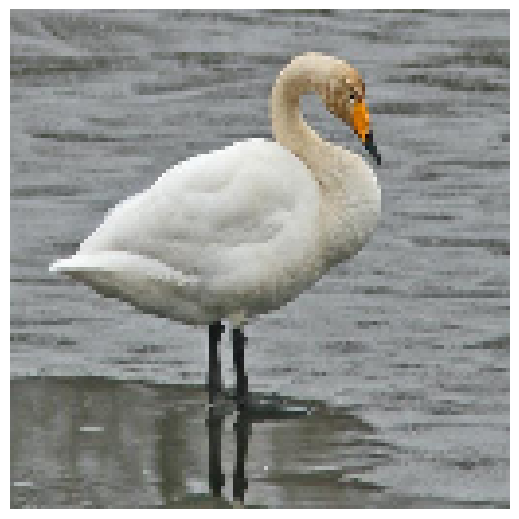


Предсказано:	малый
шипун: 2.98%
кликун: 35.63%
малый: 61.39%
Верно:		малый


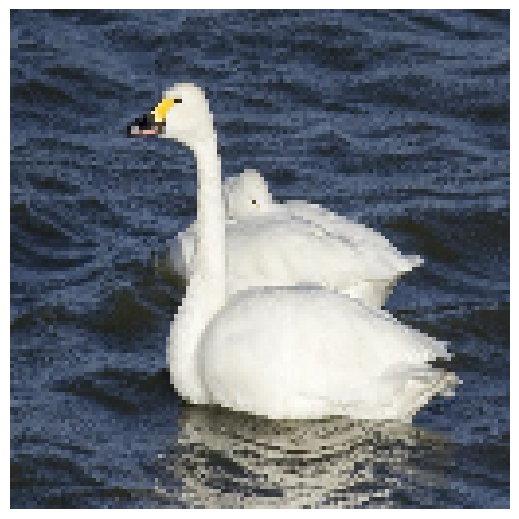


Предсказано:	кликун
шипун: 0.14%
кликун: 99.85%
малый: 0.02%
Верно:		кликун


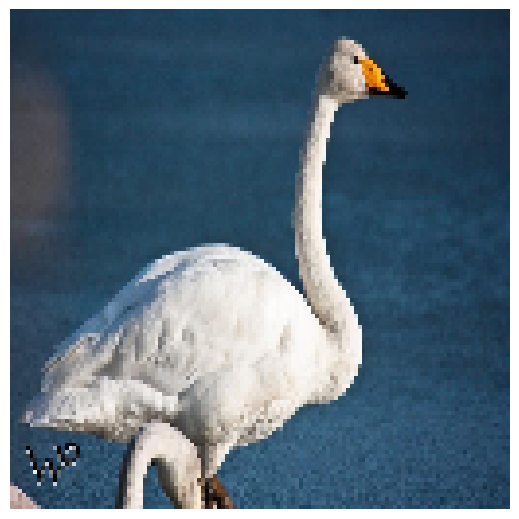


Предсказано:	кликун
шипун: 0.84%
кликун: 74.03%
малый: 25.13%
Верно:		кликун


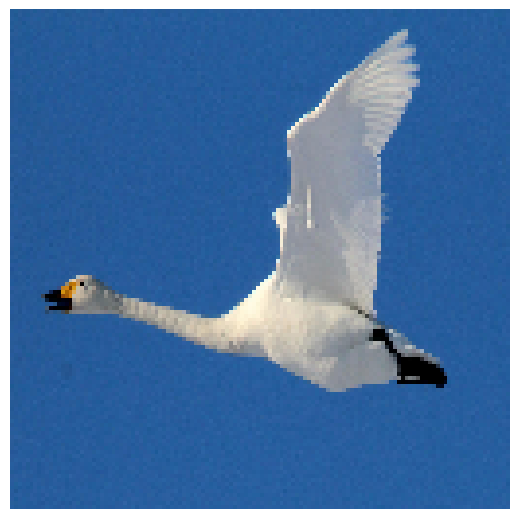


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


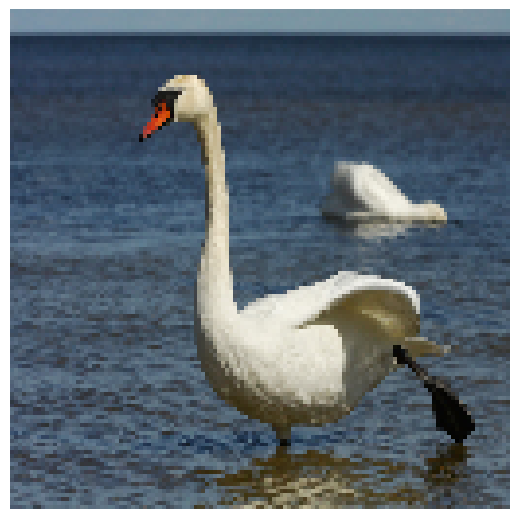


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


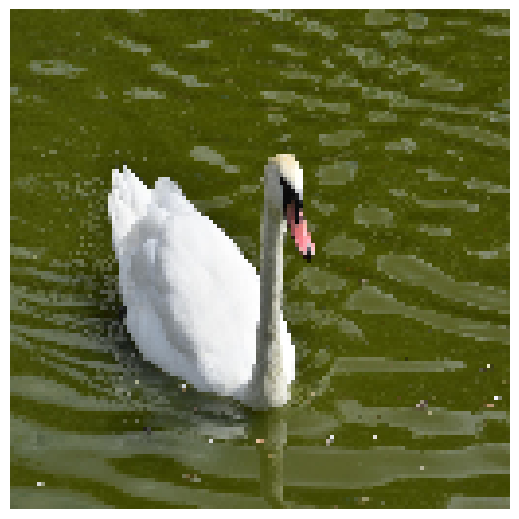


Предсказано:	малый
шипун: 0.01%
кликун: 1.29%
малый: 98.70%
Верно:		малый


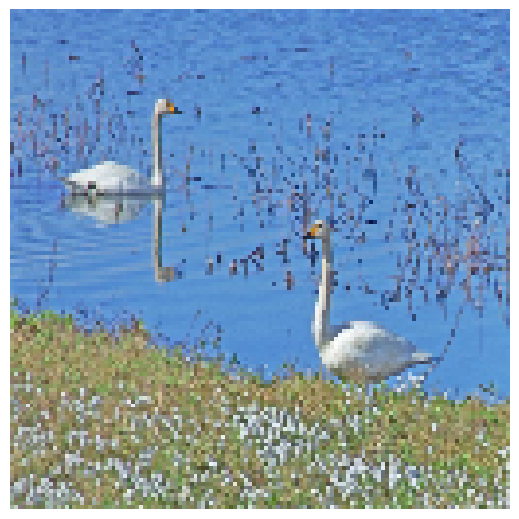


Предсказано:	кликун
шипун: 9.80%
кликун: 86.54%
малый: 3.66%
Верно:		кликун


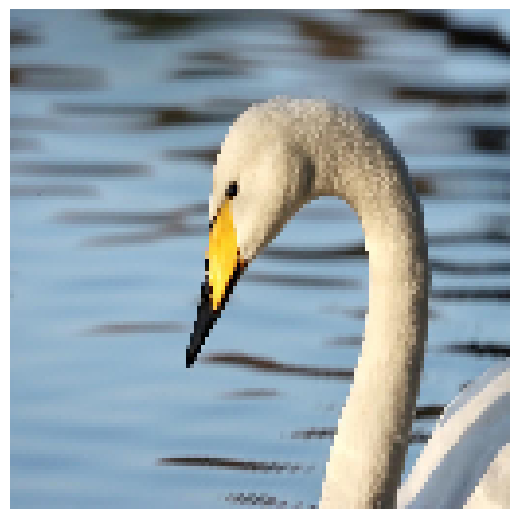


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


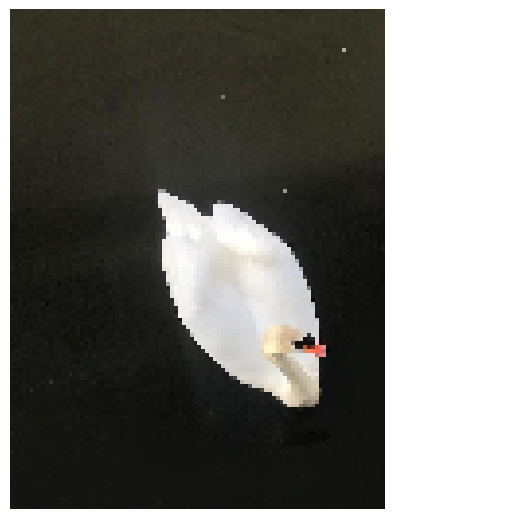


Предсказано:	малый
шипун: 0.16%
кликун: 26.57%
малый: 73.26%
Верно:		малый


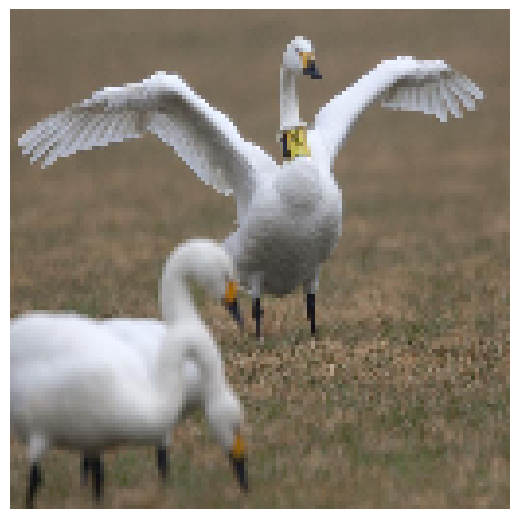


Предсказано:	малый
шипун: 2.02%
кликун: 31.95%
малый: 66.03%
Верно:		малый


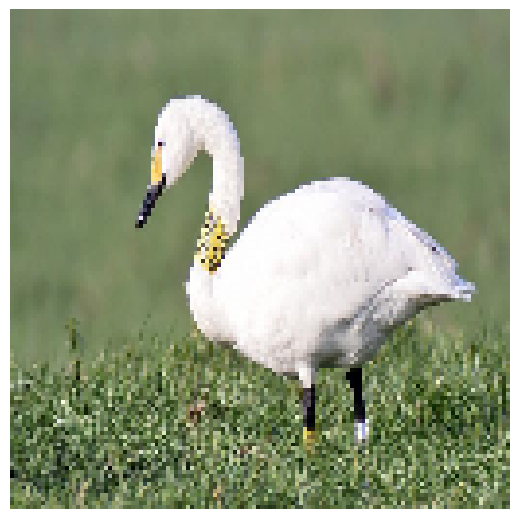


Предсказано:	кликун
шипун: 0.02%
кликун: 88.81%
малый: 11.17%
Верно:		кликун


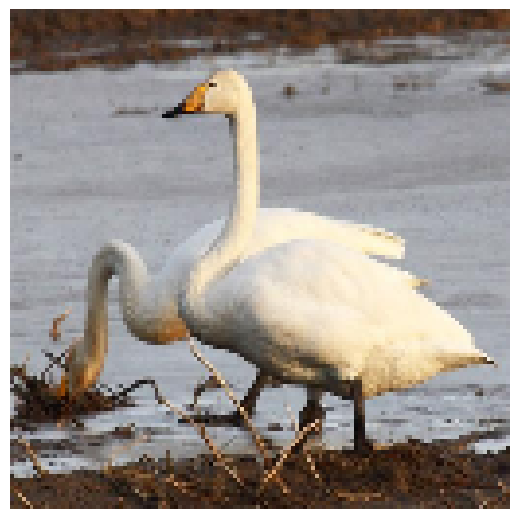


Предсказано:	малый
шипун: 0.05%
кликун: 27.41%
малый: 72.54%
Верно:		малый


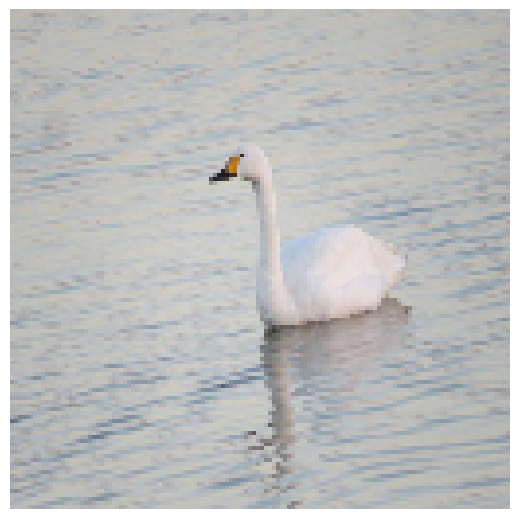


Предсказано:	кликун
шипун: 0.08%
кликун: 78.71%
малый: 21.21%
Верно:		кликун


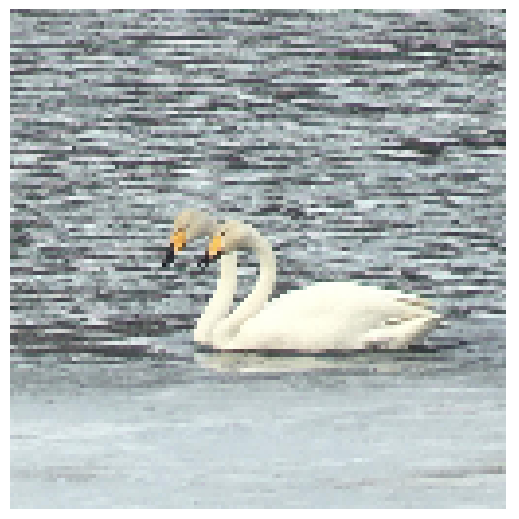


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


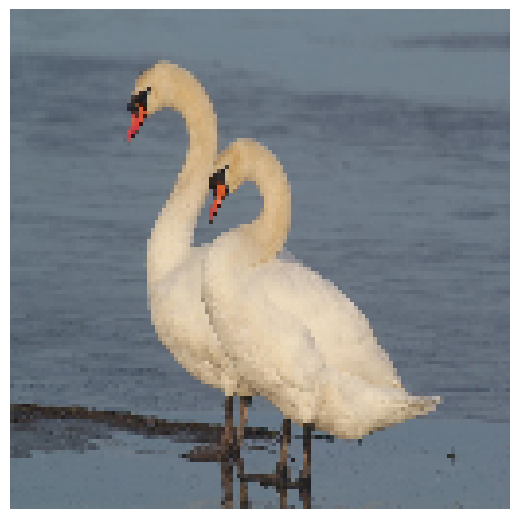


Предсказано:	кликун
шипун: 0.01%
кликун: 99.98%
малый: 0.01%
Верно:		кликун


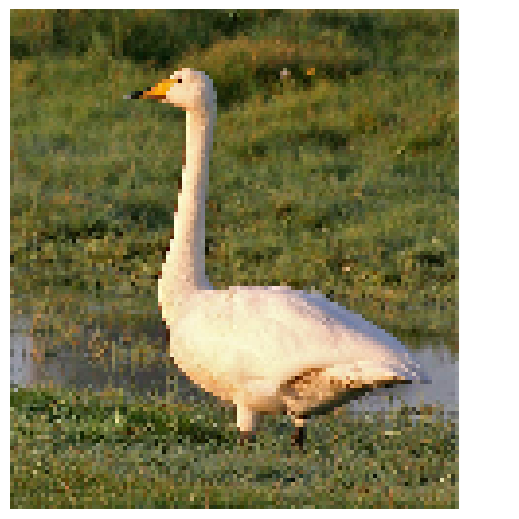


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


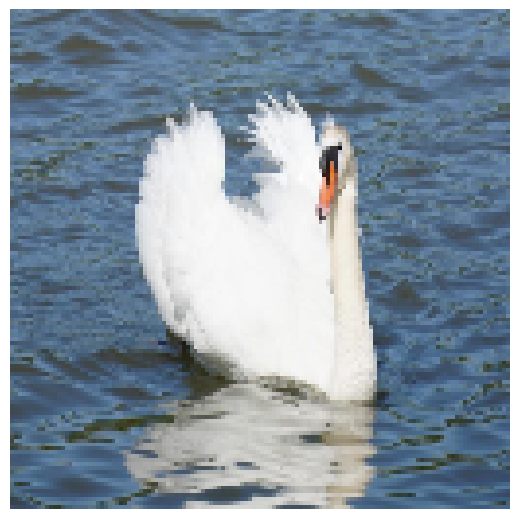


Предсказано:	кликун
шипун: 0.02%
кликун: 98.44%
малый: 1.54%
Верно:		кликун


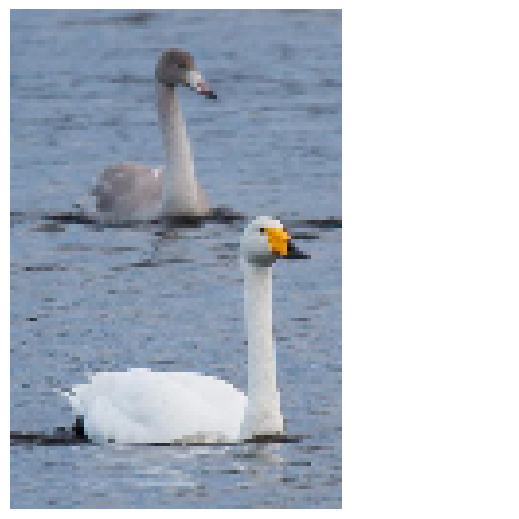


Предсказано:	шипун
шипун: 100.00%
кликун: 0.00%
малый: 0.00%
Верно:		шипун


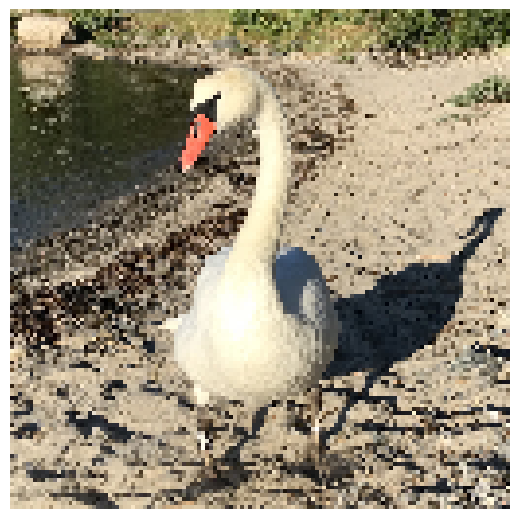

In [138]:
incorrect_ind = (predictions == true_labels)
predictions_inc = predictions[incorrect_ind]
logits_inc = logits_list[incorrect_ind, :]
probs_inc = probs[incorrect_ind, :]
true_labels_inc = true_labels[incorrect_ind]
images_inc = images_list[incorrect_ind]


def print_probs(probs):
    for i, p in enumerate(probs):
        print(f'{class_by_label[i]}: {p:.2%}')


class_by_label = {
    0: 'шипун',
    1: 'кликун',
    2: 'малый'
}
SIZE = 25
np.random.seed(1)
observations = np.random.choice(range(len(predictions_inc)), size=SIZE)
print(observations, '\n')
for i in observations:
    print(f'Предсказано:\t{class_by_label[predictions_inc[i].item()]}')
    print_probs(probs_inc[i])
    print(f'Верно:\t\t{class_by_label[true_labels_inc[i].item()]}')
    show_tensor(images_inc[i])
    print()